# Training EfficientNet
Here employ transfer learning to tune an efficientnet for AI image detection.



In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from tensorflow import data as tf_data
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt

from sklearn.model_selection import train_test_split

from preprocess_common import *

from record_save_load import *

2025-03-30 21:06:39.384916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class_names=['Human', 'AI']
AUTO = tf_data.AUTOTUNE # Parallelize data loading
#Hyperparameters
BATCH_SIZE = 64
BUFFER_SIZE = 1024
IMG_SIZE = (380,380)

SEED = 44

## Loading from TFRecords
We load the previously saved Records

For ease we provide the augmented data [here.](https://drive.google.com/file/d/16KvdZW_1Rn5zdopQtbNfej2vXxkhn1i0/view?usp=drive_link)

In [ ]:
eff_train_ds = load_tfrecord("records/efficientnet_train_blur.tfrecord", BATCH_SIZE, "efficientnet").repeat()
eff_val_ds = load_tfrecord("records/efficientnet_val.tfrecord", BATCH_SIZE, "efficientnet")

2025-03-30 21:06:43.604909: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:906] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.3/numa_node
Your kernel may have been built without NUMA support.
2025-03-30 21:06:45.549247: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:906] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.3/numa_node
Your kernel may have been built without NUMA support.
2025-03-30 21:06:45.549301: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:906] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.3/numa_node
Your kernel may have been built without NUMA support.
2025-03-30 21:06:45.553984: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:906] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.3/numa_node
Your kernel may have been built without NUMA support.
2025-03-30 21:06:45.554076: I external/local_xla/xla/stream_executor

We see below that the images are succesfully resized and Cutmixed

(380, 380, 3)


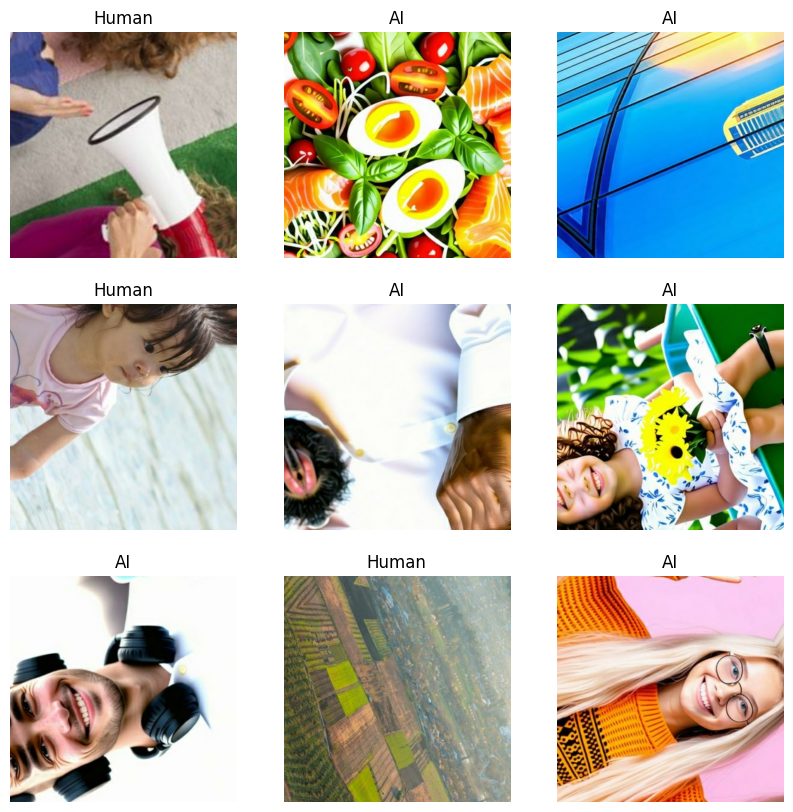

In [4]:

image_batch, label_batch = next(iter(eff_train_ds))
print(image_batch[0].shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")


## Initialize Base EfficientNet Model
We now initialize the model without the old classfication head and freeze all the initial weights

In [4]:
base_effnet_model = keras.applications.EfficientNetB4(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')
base_effnet_model.trainable = False

base_effnet_model.summary()

Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 380, 380,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 380, 380,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 380, 380,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 380, 380,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 381, 381,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 190, 190,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 190, 190,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 190, 190,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 190, 190,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 190, 190,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 190, 190,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 190, 190,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 190, 190,  │      1,152 │ block1a_se_excit

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

## Transfer Learning for new Classfication Head
### Hyperparameter search through early stopping/Hyperband optimization

Here we utilize hyperband optimization to quickly search for good performing hyperparameters, hyperband efficiently explores the parameter space and allocates more computation to parameters that work well while dropping ones that underperform. Specifically we use hyperband for the learning rate, decay steps, dropout rate, and number of hidden units. Hyperband has also been shown to outperform Bayesian Optimization in speed by 5-30x  for deep learning problems. [1](https://arxiv.org/pdf/1603.06560) 

Because of computational constraints we fix Batch Size, and Epochs and use Early Stopping on the Validation F1 Score.

We also use Categorical Focal Loss to focus the model on hard examples in order to learn more distinguishing features.

We provide the prerun hyperband files [here](https://drive.google.com/drive/folders/12kS5QrlfFyQLGImSDkKRjteh5mwp1KXy?usp=sharing)

In [ ]:
EPOCHS = 16
BATCH_SIZE = 64


In [6]:
def effnet_model(hparams):
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = base_effnet_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    units = hparams.Int("num_units", min_value=128, max_value=256, step=64)
    x = keras.layers.Dense(units, activation='relu')(x)
    dropout = hparams.Float("dropout", min_value=0.3, max_value=0.4, step=0.1)
    x = keras.layers.Dropout(dropout, seed=SEED)(x)
    outputs = keras.layers.Dense(2, activation='softmax')(x)
    effnet_model = keras.Model(inputs, outputs)
    
 
    # Tune initial learning rate
    initial_learning_rate = hparams.Float("learning_rate", min_value=1e-5, max_value=1e-4, sampling="log")
    first_decay_steps = hparams.Int("first_decay_steps", min_value=40, max_value=80, step=20)
    
    # Apply Cosine Annealing with Restarts
    lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=initial_learning_rate,
        first_decay_steps=first_decay_steps, 
        t_mul=2.0,  # Restarts period multiplier
        m_mul=0.9  # Decay factor after each restart
    )
        
    effnet_model.compile(optimizer=keras.optimizers.AdamW(lr_schedule),
                    loss=keras.losses.CategoricalFocalCrossentropy(alpha=1.0),
                    metrics=[keras.metrics.AUC(multi_label=True),
                            keras.metrics.F1Score("macro")]) 

    return effnet_model


# Define the Hyperband tuner
tuner = kt.Hyperband(
    effnet_model,
    objective=kt.Objective("val_f1_score", direction="max"),  
    max_epochs=EPOCHS,
    factor=5,  
    directory="hyperband_tuning",
    project_name="efficientnet_tuning_blur_no_cutmix"
)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=3)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs/efficientnet_tuning_blur_no_cutmix")

# Run the hyperparameter search
tuner.search(
    eff_train_ds,
    validation_data=eff_val_ds,
    epochs=EPOCHS,
    steps_per_epoch=999,
    callbacks=[early_stopping, tensorboard_callback]
)

Reloading Tuner from hyperband_tuning/efficientnet_tuning_blur_no_cutmix/tuner0.json


We can see how the hyperband algorithm explores the parameter space and culls the underperforming parameters and gives more resources to the ones that have more potential
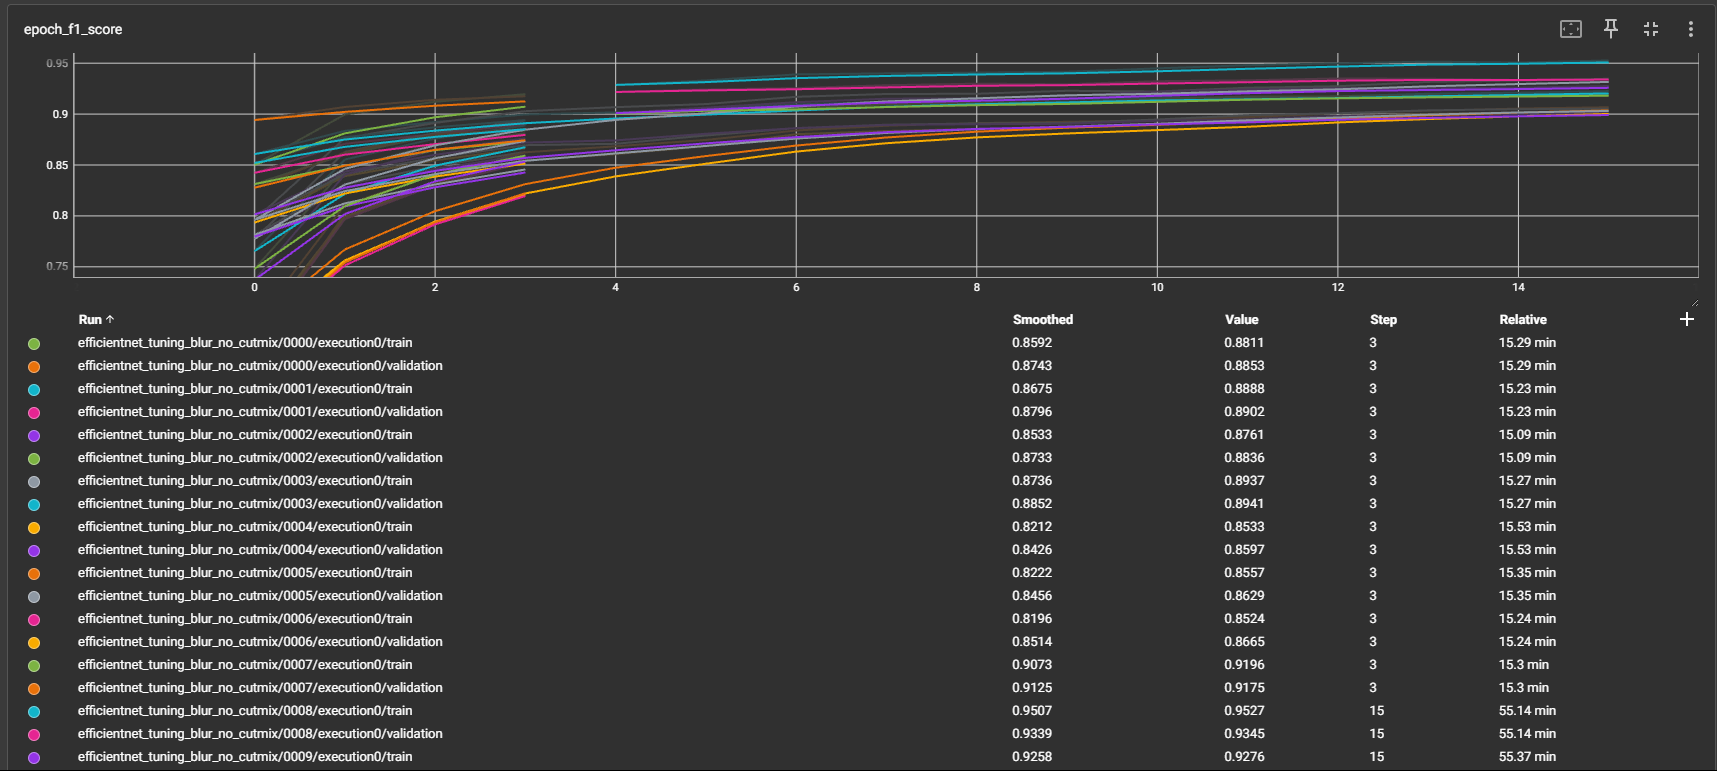

In [7]:
best_hparams = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:")
print("Num units:", best_hparams.get("num_units"))
print("Dropout:", best_hparams.get("dropout"))
print("Learning rate:", best_hparams.get("learning_rate"))
print("First decay steps:", best_hparams.get("first_decay_steps"))

Best hyperparameters:
Num units: 256
Dropout: 0.4
Learning rate: 9.23677063962739e-05
First decay steps: 40


In [ ]:
EPOCHS = 32
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

early_stopping = keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=2, min_delta=0.01, mode="max")
save_model = keras.callbacks.ModelCheckpoint(f'efficientnet_tuned_blur_no_cutmix_v2.keras', save_best_only=True)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs/efficientnet_tuning_blur_no_cutmix_v2")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)

best_model.fit(
    eff_train_ds,
    validation_data=eff_val_ds,
    epochs=EPOCHS,
    steps_per_epoch=999,
    callbacks=[early_stopping,
               save_model,
               tensorboard_callback]
)

Epoch 1/32


I0000 00:00:1743383236.066480  520979 service.cc:146] XLA service 0x7f95300049c0 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743383236.066583  520979 service.cc:154]   StreamExecutor device (0): AMD Radeon RX 7900 XTX, AMDGPU ISA version: gfx1100
2025-03-30 21:07:16.985856: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743383252.766016  520979 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


999/999 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - auc: 0.8572 - f1_score: 0.7755 - loss: 0.1200

2025-03-30 21:12:42.018851: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-30 21:12:42.019238: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/david/.pyenv/versions/3.12.9/envs/3.12stad68/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


999/999 ━━━━━━━━━━━━━━━━━━━━ 338s 311ms/step - auc: 0.8573 - f1_score: 0.7756 - loss: 0.1199 - val_auc: 0.9586 - val_f1_score: 0.8852 - val_loss: 0.0722
Epoch 2/32
999/999 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - auc: 0.9615 - f1_score: 0.8942 - loss: 0.0666

2025-03-30 21:17:56.223565: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


999/999 ━━━━━━━━━━━━━━━━━━━━ 314s 304ms/step - auc: 0.9615 - f1_score: 0.8942 - loss: 0.0666 - val_auc: 0.9685 - val_f1_score: 0.9035 - val_loss: 0.0633
Epoch 3/32
999/999 ━━━━━━━━━━━━━━━━━━━━ 307s 307ms/step - auc: 0.9705 - f1_score: 0.9098 - loss: 0.0585 - val_auc: 0.9720 - val_f1_score: 0.9076 - val_loss: 0.0599
Epoch 4/32
999/999 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - auc: 0.9750 - f1_score: 0.9173 - loss: 0.0539

2025-03-30 21:28:05.874305: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


999/999 ━━━━━━━━━━━━━━━━━━━━ 303s 303ms/step - auc: 0.9750 - f1_score: 0.9173 - loss: 0.0539 - val_auc: 0.9756 - val_f1_score: 0.9147 - val_loss: 0.0557
Epoch 5/32
999/999 ━━━━━━━━━━━━━━━━━━━━ 304s 305ms/step - auc: 0.9787 - f1_score: 0.9225 - loss: 0.0499 - val_auc: 0.9764 - val_f1_score: 0.9169 - val_loss: 0.0546
Epoch 6/32
999/999 ━━━━━━━━━━━━━━━━━━━━ 296s 297ms/step - auc: 0.9801 - f1_score: 0.9254 - loss: 0.0483 - val_auc: 0.9787 - val_f1_score: 0.9198 - val_loss: 0.0518


We can see the training score through epochs below and see the model start to overfit the training data so we engage earlystopping
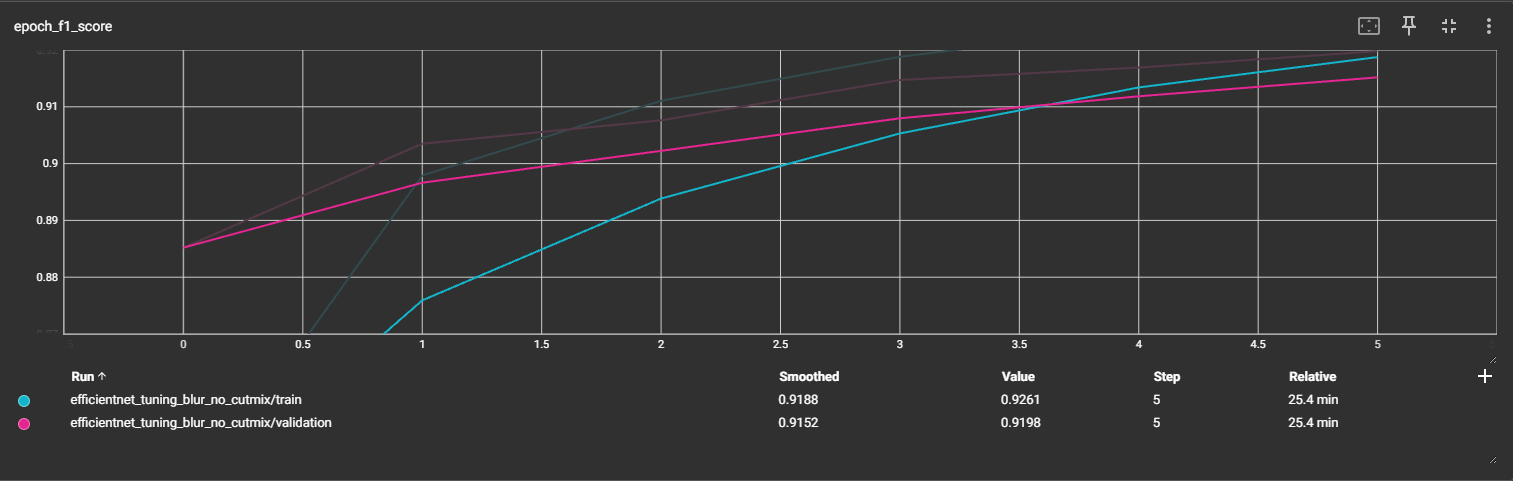

## Load and evaluate the model from .keras file and the test data
We first load the model and the test data and then use the model to predict the class of the test pictures

We provide the pretrained models [here](https://drive.google.com/drive/folders/11owFyKsbaYWEidl0p7U7SN3okqqtopnH?usp=sharing)

In [ ]:

model = keras.saving.load_model("models/efficientnet_tuned_blur_no_cutmix.keras")

test_ds = load_test_tfrecord("records/efficientnet_test.tfrecord", BATCH_SIZE, "efficientnet")

predictions = model.predict(test_ds)


87/87 ━━━━━━━━━━━━━━━━━━━━ 30s 280ms/step


In [ ]:
predicted_classes = tf.argmax(predictions, axis=1, output_type=tf.int32)
test_df = pd.read_csv("archive/test.csv")
ids = test_df["id"].values

# Convert predictions to strings for CSV output
predictions_str = tf.strings.as_string(predicted_classes)

# Create CSV content
csv_header = "id,label\n"
csv_rows = tf.strings.join([tf.strings.as_string(ids), predictions_str], separator=",")
csv_content = tf.strings.join([csv_header, tf.strings.reduce_join(csv_rows, separator="\n")])

# Save the CSV file
tf.io.write_file("effnet_submission_blur.csv", csv_content)

print("Submission saved as effnet_submission.csv")

Submission saved as effnet_submission.csv


In [ ]:
# Convert predictions to strings for CSV output
predictions_str = tf.strings.as_string(predictions)

predictions_flat = tf.strings.reduce_join(predictions_str, axis=1, separator=",")
# Create CSV content
csv_header = "id,label1,label2\n"
csv_rows = tf.strings.join([tf.strings.as_string(ids), predictions_flat], separator=",")
csv_content = tf.strings.join([csv_header, tf.strings.reduce_join(csv_rows, separator="\n")])

# Save the CSV file
tf.io.write_file("effnet_predictions_blur.csv", csv_content)

print("Predictions saved as effnet_predictions.csv")

Predictions saved as effnet_predictions_v2.csv


Despite our best efforts we see that on the test set because of the distribution shift and the many diverse models in the test set compared to the training set only coming from one we see that our performance is only at around 0.4899 for Efficient Net